# Yelp Reviews Sentiment Analysis - Preprocessing

#### Prepared By: Rabia Tariq

## Contents

* [Introduction](#Introduction)
* [Imports](#Imports)
* [Categorization](#Category)
* [TF-IDF](#Tfidf)
* [CountVectorizer](#CountVector)
* [Training Data](#Training)
    * [Logistic Regression](#Logreg)
    * [Min_df](#Min_df)
    * [N-grams](#Ngrams)
* [Conclusion](#Conclusion)

## Introduction<a id='Introduction'></a>

Uptil now we have performed data wrangling and performed exploratory data analysis. Now, in this notebook we will be doing preprocessing so we can get our data ready for modeling. We will be splitting our data and will create a simple Logistic Regression as our base model.

In this notebook, we will be labeling our data as it is unlabeled. We will also be using TF-IDF and CountVectorizer to create vectors of our cleaned reviews.

## Imports<a id='Imports'></a>

In [2]:
#!pip install pycm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from pycm import *
import operator


import warnings
warnings.filterwarnings('ignore')

In [3]:
yelp_data = pd.read_csv('yelp_data_eda.csv')
yelp_data.head()

,Alias,Name,Rating,Price,City,Zip_code,Address,Review,Word_Count,Tokens,Filtered_Sentence,StopWord_Count,%_SW,Lemmatized,Stemmed_Sentence,Stemmed_Tokens,Stemmed_Word_Count,Positive_Word_Count,%_Positive_Words,Polarity
0,morris-park-bake-shop-bronx,Morris Park Bake Shop,4.5,$$,Bronx,10462,1007 Morris Park Ave,'Morris Park Bake Shop has become my go to spo...,49,"['morris', 'park', 'bake', 'shop', 'become', '...",morris park bake shop become go spot atmosphe...,20,0.408163,morris park bake shop become go spot atmospher...,morri park bake shop becom go spot atmospher p...,"['morri', 'park', 'bake', 'shop', 'becom', 'go...",28,6,0.206897,0.338889
1,morris-park-bake-shop-bronx,Morris Park Bake Shop,4.5,$$,Bronx,10462,1007 Morris Park Ave,'I thought the cookies and biscotti were prett...,122,"['thought', 'cookies', 'biscotti', 'pretty', '...",thought cookies biscotti pretty good definite...,53,0.434426,thought cooky biscotti pretty good definitely ...,thought cooki biscotti pretti good definit tas...,"['thought', 'cooki', 'biscotti', 'pretti', 'go...",61,9,0.130435,0.314583
2,morris-park-bake-shop-bronx,Morris Park Bake Shop,4.5,$$,Bronx,10462,1007 Morris Park Ave,'Guys.... so Im a big time biscotti connoisseu...,169,"['guys', 'im', 'big', 'time', 'biscotti', 'con...",guys im big time biscotti connoisseur always ...,75,0.443787,guy im big time biscotti connoisseur always hu...,guy im big time biscotti connoisseur alway hun...,"['guy', 'im', 'big', 'time', 'biscotti', 'conn...",90,12,0.127660,0.238068
3,morris-park-bake-shop-bronx,Morris Park Bake Shop,4.5,$$,Bronx,10462,1007 Morris Park Ave,'I had a craving for a special type of cake wi...,59,"['craving', 'special', 'type', 'cake', 'ice', ...",craving special type cake ice cream layer reg...,27,0.457627,craving special type cake ice cream layer regu...,crave special type cake ice cream layer regula...,"['crave', 'special', 'type', 'cake', 'ice', 'c...",30,7,0.218750,0.314643
4,morris-park-bake-shop-bronx,Morris Park Bake Shop,4.5,$$,Bronx,10462,1007 Morris Park Ave,'The chocolate cups are amazing! Have been eat...,16,"['chocolate', 'cups', 'amazing', 'eating', 'ye...",chocolate cups amazing eating years always ta...,7,0.437500,chocolate cup amazing eating year always taste...,chocol cup amaz eat year alway tast fantast,"['chocol', 'cup', 'amaz', 'eat', 'year', 'alwa...",8,2,0.222222,0.500000


## Categorization<a id='Category'></a>

Since our data is unlabeled, first we have to create the categories i.e. __'Positive', 'Negative'__ which are going to be used by our model to sort the reviews for our sentiment analysis. We are going to be doing that using the Polarity.  

In [4]:
yelp_data_cat = yelp_data[yelp_data['Polarity'] != 0]
yelp_data_cat = yelp_data_cat.reset_index()

In [5]:
label = []
for i in range(len(yelp_data_cat)):
    if yelp_data_cat['Polarity'][i] > 0:
        label.append('Positive')
    if yelp_data_cat['Polarity'][i] < 0:
        label.append('Negative')
yelp_data_cat['label'] = label

Now lets graphically look at the distribution of positive and negative comments in our data

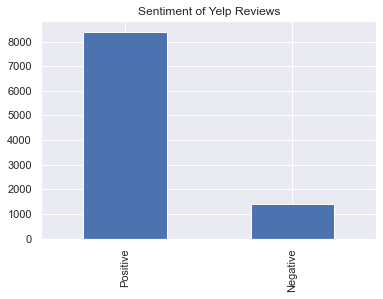

In [8]:
yelp_data_cat['label'].value_counts().plot(kind='bar')
plt.title('Sentiment of Yelp Reviews');

Here we can see that most of the reviews are positive. According to yelp, most Yelp community members usually write more positive than negative reviews. So, it is expected.

https://www.yelp-support.com/article/Does-Yelp-recommend-more-positive-or-negative-reviews?l=en_US

In [6]:
label = []

for i in range(len(yelp_data_cat)):
    if yelp_data_cat['Polarity'][i] < 0:
        label.append('Negative')
    if yelp_data_cat['Polarity'][i] > 0 and yelp_data_cat['Polarity'][i] <= 0.2:
        label.append('Somewhat Negative')
    if yelp_data_cat['Polarity'][i] > 0.2 and yelp_data_cat['Polarity'][i] < 0.4:
        label.append('Somewhat Positive')
    if yelp_data_cat['Polarity'][i] >= 0.4:
        label.append('Positive')

yelp_data_cat['label'] = label

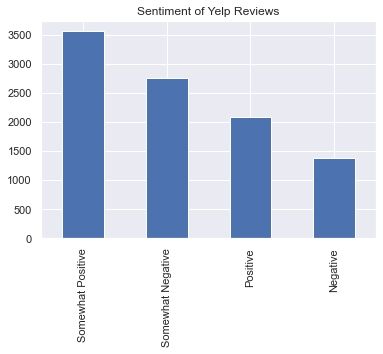

In [7]:
yelp_data_cat['label'].value_counts().plot(kind='bar')
plt.title('Sentiment of Yelp Reviews');

Now we are going to be using TFIDF and Count Vectorizer to the reviews into word vectors.

## TF-IDF<a id='Tfidf'></a>

TF-IDF stands for “Term Frequency — Inverse Document Frequency”. This is a technique to quantify words in a set of documents. We generally compute a score for each word to signify its importance in the document and corpus.

This source tells how it works and how to use it

https://www.geeksforgeeks.org/understanding-tf-idf-term-frequency-inverse-document-frequency/

In [8]:
review = yelp_data_cat['Filtered_Sentence'][0:2]
tfidf = TfidfVectorizer()
tfidf.fit(review)
result = tfidf.transform(review)

#summary
print('List of unique Words: ',tfidf.vocabulary_)
print('')
print('Shape of the Sparse Matrix ',result.shape)
print('')
print(result.toarray())

List of unique Words:  {'morris': 39, 'park': 42, 'bake': 8, 'shop': 52, 'become': 9, 'go': 24, 'spot': 54, 'atmosphere': 6, 'place': 43, 'great': 26, 'inviting': 30, 'love': 33, 'every': 19, 'thing': 59, 'ordered': 41, 'staff': 55, 'really': 49, 'pleasant': 45, 'definitely': 17, 'help': 28, 'anything': 5, 'come': 15, 'back': 7, 'thought': 60, 'cookies': 16, 'biscotti': 11, 'pretty': 47, 'good': 25, 'tasty': 56, 'nothing': 40, 'blew': 12, 'water': 64, 'rock': 50, 'hard': 27, 'almond': 2, 'probably': 48, 'best': 10, 'however': 29, 'didnt': 18, 'feel': 20, 'wonderfully': 67, 'safe': 51, 'walked': 63, 'man': 34, 'toward': 61, 'mask': 35, 'another': 4, 'female': 21, 'member': 37, 'chin': 14, '13': 0, 'members': 38, 'masks': 36, 'isnt': 31, 'walk': 62, 'additionally': 1, 'theyre': 58, 'cash': 13, 'whatever': 66, 'know': 32, 'plenty': 46, 'places': 44, 'wouldnt': 68, 'way': 65, 'get': 23, 'something': 53, 'already': 3, 'thats': 57, 'fine': 22}

Shape of the Sparse Matrix  (2, 69)

[[0.      

## CountVectorizer<a id='CountVector'></a>

CountVectorizer is a great tool provided by the scikit-learn library in Python. It is used to transform a given text into a vector on the basis of the frequency (count) of each word that occurs in the entire text. This is helpful when we have multiple such texts, and we wish to convert each word in each text into vectors (for using in further text analysis).

https://www.geeksforgeeks.org/using-countvectorizer-to-extracting-features-from-text/

In [13]:
review = yelp_data_cat['Filtered_Sentence'][0:2]
vectorizer = CountVectorizer()
vectorizer.fit(review)
vector = vectorizer.transform(review)

#summary
print('List of unique Words: ',vectorizer.vocabulary_)
print('')
print('Shape of the Sparse Matrix ',vector.shape)
print('')
print(vector.toarray())

List of unique Words:  {'morris': 39, 'park': 42, 'bake': 8, 'shop': 52, 'become': 9, 'go': 24, 'spot': 54, 'atmosphere': 6, 'place': 43, 'great': 26, 'inviting': 30, 'love': 33, 'every': 19, 'thing': 59, 'ordered': 41, 'staff': 55, 'really': 49, 'pleasant': 45, 'definitely': 17, 'help': 28, 'anything': 5, 'come': 15, 'back': 7, 'thought': 60, 'cookies': 16, 'biscotti': 11, 'pretty': 47, 'good': 25, 'tasty': 56, 'nothing': 40, 'blew': 12, 'water': 64, 'rock': 50, 'hard': 27, 'almond': 2, 'probably': 48, 'best': 10, 'however': 29, 'didnt': 18, 'feel': 20, 'wonderfully': 67, 'safe': 51, 'walked': 63, 'man': 34, 'toward': 61, 'mask': 35, 'another': 4, 'female': 21, 'member': 37, 'chin': 14, '13': 0, 'members': 38, 'masks': 36, 'isnt': 31, 'walk': 62, 'additionally': 1, 'theyre': 58, 'cash': 13, 'whatever': 66, 'know': 32, 'plenty': 46, 'places': 44, 'wouldnt': 68, 'way': 65, 'get': 23, 'something': 53, 'already': 3, 'thats': 57, 'fine': 22}

Shape of the Sparse Matrix  (2, 69)

[[0 0 0 0 

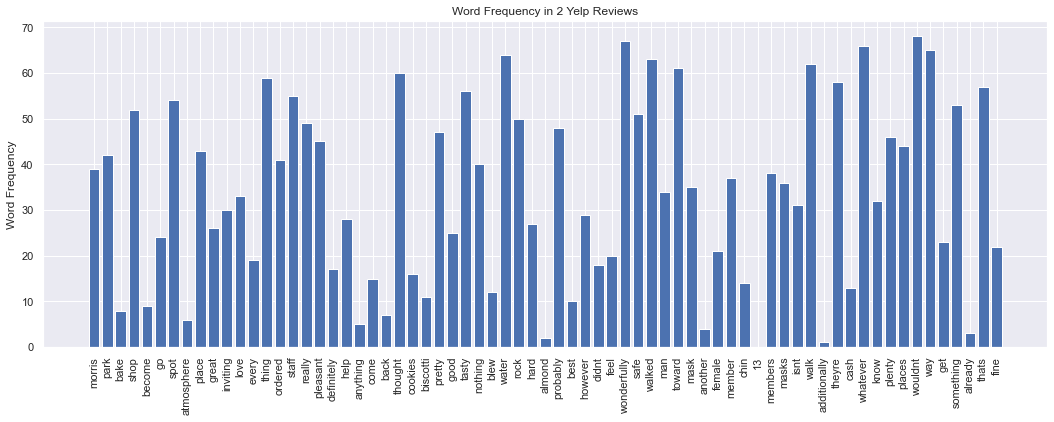

In [19]:
lists = vectorizer.vocabulary_.items() # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.figure(figsize=(18,6))
plt.bar(x, y)
plt.xticks(rotation='vertical')
plt.title('Word Frequency in 2 Yelp Reviews')
plt.ylabel('Word Frequency')
plt.show()

We got 69 unique words in the first two reviews.

## Training Data<a id='Training'></a>

In [8]:
review = yelp_data_cat['Stemmed_Sentence']
tfidf = TfidfVectorizer()
tfidf.fit(review)
result = tfidf.transform(review)

In [9]:
vocab = tfidf.vocabulary_
df = pd.DataFrame(result.toarray(),columns = vocab)

col_1 ='Name'
col_2 = 'Review'
col_3 = 'Polarity'
col_4 = 'Sentiment'
col_5 = '%_Positive_Words'

col1 = yelp_data_cat['Name']
col2 = yelp_data_cat['Review']
col3 = yelp_data_cat['Polarity']
col4 = yelp_data_cat['label']
col5 = yelp_data_cat['%_Positive_Words']

df.insert(0,col_1,col1)
df.insert(1,col_2,col2)
df.insert(2,col_3,col3)
df.insert(3,col_4,col4)
df.insert(4,col_5,col5)

In [10]:
df.head(2)

,Name,Review,Polarity,Sentiment,%_Positive_Words,morri,park,bake,shop,becom,...,pepperour,resourceful,memiri,nigh,firework,whenwer,matredown,becausenow,donn,lectern
0,Morris Park Bake Shop,'Morris Park Bake Shop has become my go to spo...,0.338889,Somewhat Positive,0.206897,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Morris Park Bake Shop,'I thought the cookies and biscotti were prett...,0.314583,Somewhat Positive,0.130435,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Logistic Regression<a id='Logreg'></a>

The first step for our modeling will be to create a simple model to classify our data using Logistic Regression

Accuracy Score:  0.6630360789652825

Overall Statistics : 

ACC Macro                                                         0.83152
F1 Macro                                                          0.66835
FPR Macro                                                         0.12192
Kappa                                                             0.52627
Overall ACC                                                       0.66304
PPV Macro                                                         0.70186
SOA1(Landis & Koch)                                               Moderate
TPR Macro                                                         0.64855
Zero-one Loss                                                     990

Class Statistics :

Classes                                                           Negative              Positive              Somewhat Negative     Somewhat Positive     
ACC(Accuracy)                                                     0.91899               0.8853       

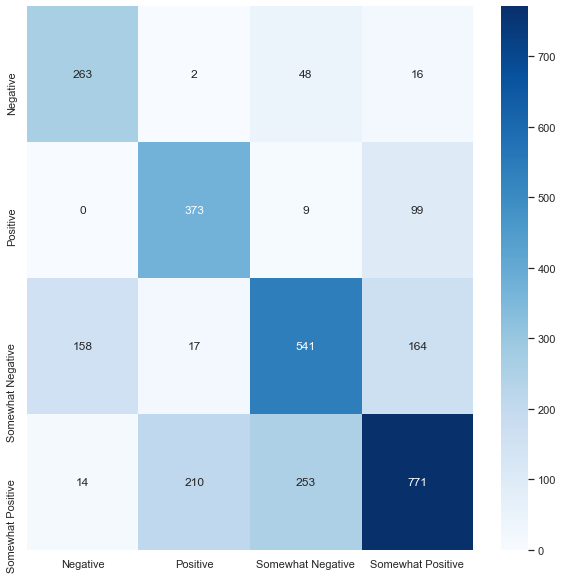

In [11]:
X = df.iloc[0:,4:]
y = df.Sentiment

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0, test_size = 0.3)

l_reg = LogisticRegression(solver = 'lbfgs')
model = Pipeline([('classifier',l_reg)])
model.fit(X_train, y_train)
pred = model.predict(X_test)
mat = confusion_matrix(pred,y_test)
cm_df =  pd.DataFrame(mat, index= [i for i in ['Negative','Positive',
                                               'Somewhat Negative',
                                              'Somewhat Positive']],
                     columns= [i for i in ['Negative','Positive',
                                               'Somewhat Negative',
                                              'Somewhat Positive']])
plt.figure(figsize=(10,10))
sns.heatmap(cm_df, annot=True,cmap='Blues',fmt='g')

cm = ConfusionMatrix(actual_vector=list(y_test), predict_vector = list(pred))
print('Accuracy Score: ',accuracy_score(pred, y_test))
print('')
cm.stat(summary=True)


### Min_df<a id='Min_df'></a>

With simple logistic regression, we get accuracy of 66%. To improve this and avoid overfitting, we are going to change min/max_df.

min_df is used for removing terms that appear too infrequently. For example:
- min_df = 0.01 means "ignore terms that appear in less than 1% of the documents".
- min_df = 5 means "ignore terms that appear in less than 5 documents".

max_df is used for removing terms that appear too frequently, also known as "corpus-specific stop words". For example:
- max_df = 0.50 means "ignore terms that appear in more than 50% of the documents".
- max_df = 25 means "ignore terms that appear in more than 25 documents".

In [15]:
def min_df(num):
    scores = {}
    
    for i in num:
        review = yelp_data_cat['Stemmed_Sentence']
        tfidf = TfidfVectorizer(min_df = i)
        tfidf.fit(review)
        result = tfidf.transform(review)

        vocab = tfidf.vocabulary_
        df = pd.DataFrame(result.toarray(),columns = vocab)

        col_1 ='Name'
        col_2 = 'Review'
        col_3 = 'Polarity'
        col_4 = 'Sentiment'
        col_5 = '%_Positive_Words'

        col1 = yelp_data_cat['Name']
        col2 = yelp_data_cat['Review']
        col3 = yelp_data_cat['Polarity']
        col4 = yelp_data_cat['label']
        col5 = yelp_data_cat['%_Positive_Words']

        df.insert(0,col_1,col1)
        df.insert(1,col_2,col2)
        df.insert(2,col_3,col3)
        df.insert(3,col_4,col4)
        df.insert(4,col_5,col5)


        X = df.iloc[0:,4:]
        y = df.Sentiment

        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0, test_size = 0.3)

        l_reg = LogisticRegression(solver = 'lbfgs')
        model = Pipeline([('classifier',l_reg)])
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        
        score = accuracy_score(pred, y_test)
        
        scores[i] = score
        
    return scores

In [17]:
min_1 = list(range(5,55))
scores_1 = min_df(min_1)

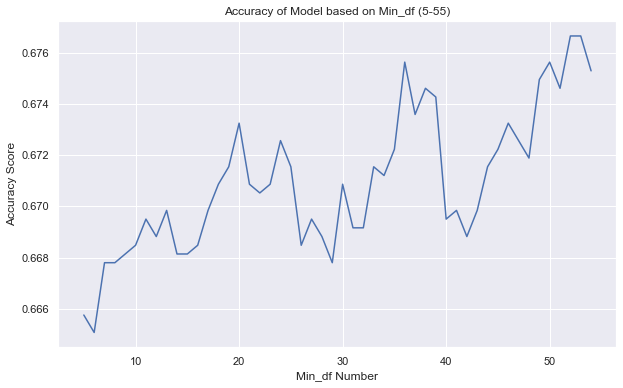

In [21]:
x = scores_1.keys()
y = scores_1.values()
plt.figure(figsize=(10,6))
plt.plot(x,y)
plt.title('Accuracy of Model based on Min_df (5-55)')
plt.xlabel('Min_df Number')
plt.ylabel('Accuracy Score');

In [19]:
max(scores_1.items(), key = operator.itemgetter(1))[0]

52

52 is the best for min_df

### N-grams<a id='Ngrams'></a>

Now lets check if the accuracy of our model increases with changing the number of ngrams

In [22]:
def ngram(num):
    scores = {}
    
    for i in num:
        review = yelp_data_cat['Stemmed_Sentence']
        tfidf = TfidfVectorizer(ngram_range=(1,i), min_df = 52)
        tfidf.fit(review)
        result = tfidf.transform(review)

        vocab = tfidf.vocabulary_
        df = pd.DataFrame(result.toarray(),columns = vocab)

        col_1 ='Name'
        col_2 = 'Review'
        col_3 = 'Polarity'
        col_4 = 'Sentiment'
        col_5 = '%_Positive_Words'

        col1 = yelp_data_cat['Name']
        col2 = yelp_data_cat['Review']
        col3 = yelp_data_cat['Polarity']
        col4 = yelp_data_cat['label']
        col5 = yelp_data_cat['%_Positive_Words']

        df.insert(0,col_1,col1)
        df.insert(1,col_2,col2)
        df.insert(2,col_3,col3)
        df.insert(3,col_4,col4)
        df.insert(4,col_5,col5)


        X = df.iloc[0:,4:]
        y = df.Sentiment

        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0, test_size = 0.3)

        l_reg = LogisticRegression(solver = 'lbfgs')
        model = Pipeline([('classifier',l_reg)])
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        
        score = accuracy_score(pred, y_test)
        
        scores[i] = score
        
    return scores

In [26]:
ngram_list = [1,2,3,4]
ngram_scores = ngram(ngram_list)

Text(0, 0.5, 'Accuracy Score')

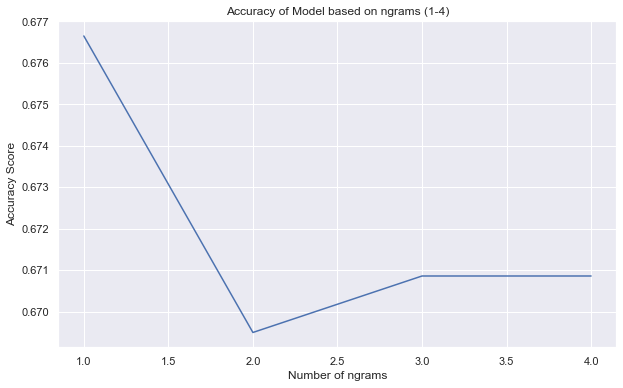

In [28]:
x = ngram_scores.keys()
y = ngram_scores.values()
plt.figure(figsize=(10,6))
plt.plot(x,y)
plt.title('Accuracy of Model based on ngrams (1-4)')
plt.xlabel('Number of ngrams')
plt.ylabel('Accuracy Score')

### Final Dataset<a id='Final'></a>

In [29]:
review = yelp_data_cat['Stemmed_Sentence']
tfidf = TfidfVectorizer(min_df = 52, ngram_range = (1,2))
tfidf.fit(review)
result = tfidf.transform(review)

vocab = tfidf.vocabulary_
df = pd.DataFrame(result.toarray(),columns = vocab)

col_1 ='Name'
col_2 = 'Review'
col_3 = 'Polarity'
col_4 = 'Sentiment'
col_5 = '%_Positive_Words'

col1 = yelp_data_cat['Name']
col2 = yelp_data_cat['Review']
col3 = yelp_data_cat['Polarity']
col4 = yelp_data_cat['label']
col5 = yelp_data_cat['%_Positive_Words']

df.insert(0,col_1,col1)
df.insert(1,col_2,col2)
df.insert(2,col_3,col3)
df.insert(3,col_4,col4)
df.insert(4,col_5,col5)

In [30]:
df.head(2)

,Name,Review,Polarity,Sentiment,%_Positive_Words,park,bake,shop,becom,go,...,sangria,time squar,jukebox,calzon,byob,pizzeria,bake clam,castl,white castl,drive thru
0,Morris Park Bake Shop,'Morris Park Bake Shop has become my go to spo...,0.338889,Somewhat Positive,0.206897,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Morris Park Bake Shop,'I thought the cookies and biscotti were prett...,0.314583,Somewhat Positive,0.130435,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
df.to_csv(r'yelp_data_preprocessing.csv',index=False)

## Conclusion<a id='Conclusion'></a>

Now we have our dataset which we can use with better models. With just our simple Logistic Regression model we were able to achieve ~ 68% accuracy. This is a reasonable start to our modeling. But with better models we will hopefully be able to achieve better accuracy and performance. That will be our next step. 